<h1 style = "color:navy;"><center>Toyota Corolla Car Price Prediction</center></h1>

Import all necessary modules

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler     #for scaling the features before modelling
from sklearn.model_selection import train_test_split        #for spliting the dataset into training and testing dataset
from sklearn.linear_model import LinearRegression        #Linear Regression model
from sklearn.metrics import mean_squared_error, r2_score   #metrics to check the performance of the model
import statsmodels.formula.api as smf        #to check the p value of each features
from sklearn.preprocessing import PolynomialFeatures       #to create polynomial features
from sklearn.linear_model import LassoCV      #Model for Lasso regularization method
from sklearn.linear_model import Ridge          #Model for Ridge regularization method


import warnings
warnings.filterwarnings('ignore')

toyota = pd.read_csv("ToyotaCorolla - MLR.csv")
sns.set_palette('Set2')

<h2 style = "color:indigo;"> 1. Data understanding and cleaning</h2>

In [98]:
toyota.nunique()

Price         236
Age_08_04      77
KM           1263
Fuel_Type       3
HP             12
Automatic       2
cc             13
Doors           4
Cylinders       1
Gears           4
Weight         59
dtype: int64

Let's rename the age column and captialize CC

In [99]:
toyota.rename(columns ={'Age_08_04':'Years','cc':'CC'}, inplace=True)

Cylinders only have one unique value in the dataset, so let's check and then drop that column as there is no special information to be derived from the column.

In [100]:
toyota['Cylinders'].unique()

array([4], dtype=int64)

In [101]:
toyota.drop(columns='Cylinders', inplace = True)
toyota.head()

,Price,Years,KM,Fuel_Type,HP,Automatic,CC,Doors,Gears,Weight
0,13500,23,46986,Diesel,90,0,2000,3,5,1165
1,13750,23,72937,Diesel,90,0,2000,3,5,1165
2,13950,24,41711,Diesel,90,0,2000,3,5,1165
3,14950,26,48000,Diesel,90,0,2000,3,5,1165
4,13750,30,38500,Diesel,90,0,2000,3,5,1170


Checking the kind of data types in each column

In [102]:
toyota.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1436 non-null   int64 
 1   Years      1436 non-null   int64 
 2   KM         1436 non-null   int64 
 3   Fuel_Type  1436 non-null   object
 4   HP         1436 non-null   int64 
 5   Automatic  1436 non-null   int64 
 6   CC         1436 non-null   int64 
 7   Doors      1436 non-null   int64 
 8   Gears      1436 non-null   int64 
 9   Weight     1436 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 112.3+ KB


1. <b>Numeric:</b> Price, Age, KM, HP, CC, Weight
2. <b>Categorical:</b> Fuel_Type, Automatic, Doors, Gears(We will consider Door and Gears as  categorical ordinal variable)

We will change the type of the categorical variable to category

In [103]:
toyota['Fuel_Type'] = toyota['Fuel_Type'].astype('category')
toyota['Automatic'] = toyota['Automatic'].astype('category')
toyota['Price'] = toyota['Price'].astype('float')
toyota['Doors'] = toyota['Doors'].astype('category')
toyota['Gears'] = toyota['Gears'].astype('category')

In [104]:
toyota.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Price      1436 non-null   float64 
 1   Years      1436 non-null   int64   
 2   KM         1436 non-null   int64   
 3   Fuel_Type  1436 non-null   category
 4   HP         1436 non-null   int64   
 5   Automatic  1436 non-null   category
 6   CC         1436 non-null   int64   
 7   Doors      1436 non-null   category
 8   Gears      1436 non-null   category
 9   Weight     1436 non-null   int64   
dtypes: category(4), float64(1), int64(5)
memory usage: 73.6 KB


Checking for duplicates and deleting them if we have any

In [105]:
toyota[toyota.duplicated()]

,Price,Years,KM,Fuel_Type,HP,Automatic,CC,Doors,Gears,Weight
113,24950.0,8,13253,Diesel,116,0,2000,5,5,1320


In [106]:
toyota.drop(index=toyota[toyota.duplicated()].index, inplace=True)

In [107]:
toyota.describe()

,Price,Years,KM,HP,CC,Weight
count,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000
mean,10720.915679,55.980488,68571.782578,101.491986,1576.560976,1072.287108
std,3608.732978,18.563312,37491.094553,14.981408,424.387533,52.251882
min,4350.000000,1.000000,1.000000,69.000000,1300.000000,1000.000000
25%,8450.000000,44.000000,43000.000000,90.000000,1400.000000,1040.000000
50%,9900.000000,61.000000,63451.000000,110.000000,1600.000000,1070.000000
75%,11950.000000,70.000000,87041.500000,110.000000,1600.000000,1085.000000
max,32500.000000,80.000000,243000.000000,192.000000,16000.000000,1615.000000


In [108]:
toyota.shape

(1435, 10)

For reusability, the function below is to check the percentile value and the numberof value above it

In [109]:
def get_percentile_info(dataframe, column, percentile):   
    percentile_value = np.percentile(dataframe[column], percentile)     #get the percentile value
    count_below = (dataframe[column] < percentile_value).sum()      #count the number of values under the percentile
    return f'{percentile} percentile value = {percentile_value}, there are { 1435 - count_below} values above it.'

### Target Analysis
Price column is our target variable, IQR is between 8450 and 11950.
Let's check out the distribution to get more idea


#### Price

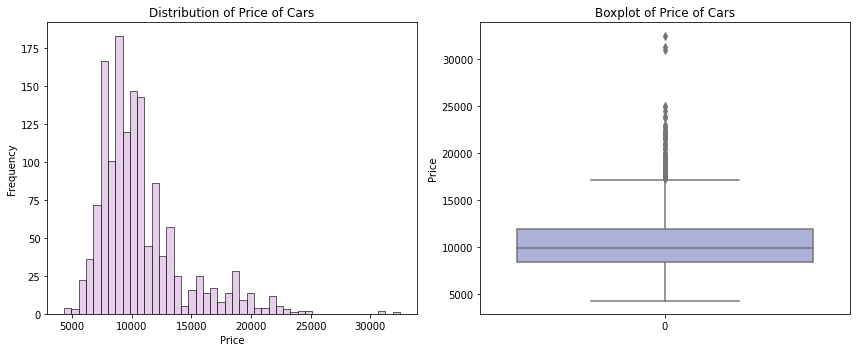

In [110]:
# Set up the subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
sns.histplot(data=toyota['Price'], color='#DEBEE5', ax=axes[0])
axes[0].set_title('Distribution of Price of Cars')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Price')

# Plot the boxplot
sns.boxplot(data=toyota['Price'], color='#A7ABDE', ax=axes[1])
axes[1].set_title('Boxplot of Price of Cars')
axes[1].set_ylabel('Price')

# Adjust layout
plt.tight_layout()
plt.show()

In [111]:
get_percentile_info(toyota,'Price',95)

'95 percentile value = 18914.999999999996, there are 72 values above it.'

In [112]:
get_percentile_info(toyota,'Price',99)

'99 percentile value = 22250.0, there are 16 values above it.'

### Feature Analysis

#### 1. Years

IQR is 44 - 70 and the mean years is 56. Let's look at the distribution and boxplot


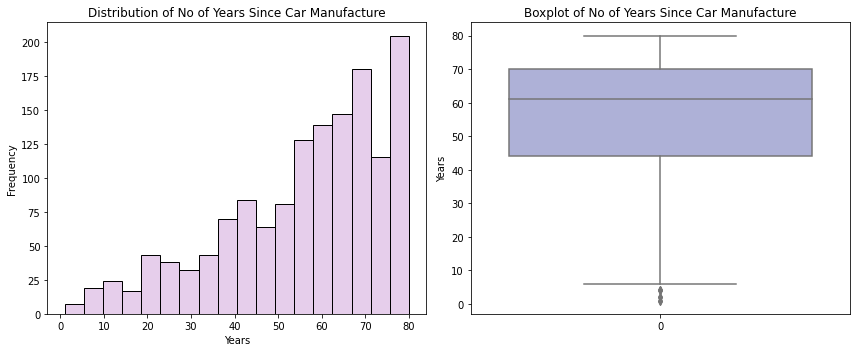

In [113]:
# Set up the subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
sns.histplot(data=toyota['Years'], color='#DEBEE5', ax=axes[0])
axes[0].set_title('Distribution of No of Years Since Car Manufacture')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Years')

# Plot the boxplot
sns.boxplot(data=toyota['Years'], color='#A7ABDE', ax=axes[1])
axes[1].set_title('Boxplot of No of Years Since Car Manufacture')
axes[1].set_ylabel('Years')

# Adjust layout
plt.tight_layout()
plt.show()

The distribution is negative skewed and it has some outliers below lower quartile.
We have decided that this outlier need not to be removed as there is possibility that new cars might hold some significant information. Also, the outliers are not that far from the 5th percentile

#### 2.KM

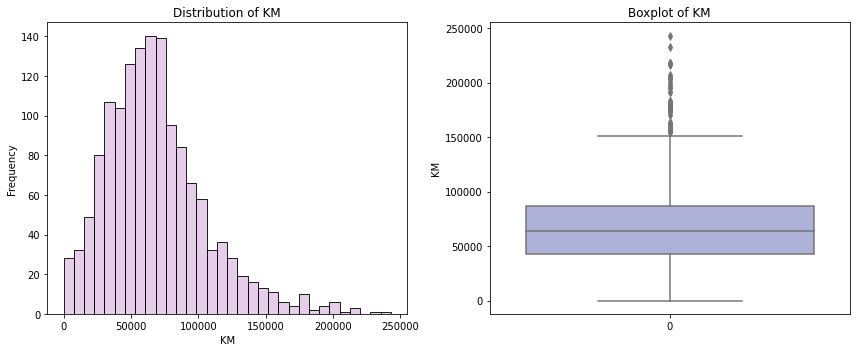

In [114]:
# Set up the subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
sns.histplot(data=toyota['KM'], color='#DEBEE5', ax=axes[0])
axes[0].set_title('Distribution of KM')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('KM')

# Plot the boxplot
sns.boxplot(data=toyota['KM'], color='#A7ABDE', ax=axes[1])
axes[1].set_title('Boxplot of KM')
axes[1].set_ylabel('KM')

# Adjust layout
plt.tight_layout()
plt.show()

In [115]:
get_percentile_info(toyota,'KM',99)

'99 percentile value = 191375.20000000007, there are 15 values above it.'

In [116]:
get_percentile_info(toyota,'KM',95)

'95 percentile value = 138425.8, there are 72 values above it.'

The distribution looks similar to the target variable, hence we won't deal with the outliers. Instead,we will create the logarithmic values of this column separately and then check the correlation to the target variable later

In [117]:
toyota['log_KM'] = np.log1p(toyota['KM'])

#### 3. HP

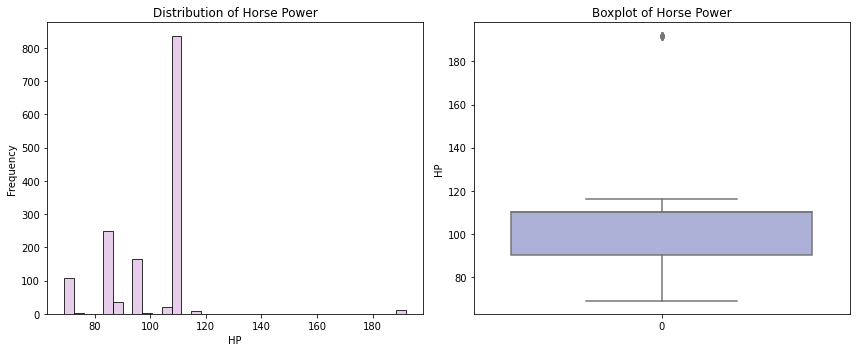

In [118]:
# Set up the subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
sns.histplot(data=toyota['HP'], color='#DEBEE5', ax=axes[0])
axes[0].set_title('Distribution of Horse Power')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('HP')

# Plot the boxplot
sns.boxplot(data=toyota['HP'], color='#A7ABDE', ax=axes[1])
axes[1].set_title('Boxplot of Horse Power')
axes[1].set_ylabel('HP')

# Adjust layout
plt.tight_layout()
plt.show()

In [119]:
toyota[toyota['HP']> 120]

,Price,Years,KM,Fuel_Type,HP,Automatic,CC,Doors,Gears,Weight,log_KM
8,21500.0,27,19700,Petrol,192,0,1800,3,5,1185,9.888425
10,20950.0,25,31461,Petrol,192,0,1800,3,6,1185,10.356536
11,19950.0,22,43610,Petrol,192,0,1800,3,6,1185,10.683065
12,19600.0,25,32189,Petrol,192,0,1800,3,6,1185,10.379411
13,21500.0,31,23000,Petrol,192,0,1800,3,6,1185,10.043293
14,22500.0,32,34131,Petrol,192,0,1800,3,6,1185,10.437991
15,22000.0,28,18739,Petrol,192,0,1800,3,6,1185,9.838416
16,22750.0,30,34000,Petrol,192,0,1800,3,5,1185,10.434145
49,21950.0,31,64982,Petrol,192,0,1800,5,6,1195,11.081881
53,21950.0,27,49866,Petrol,192,0,1800,5,5,1195,10.817115


We will use log transformation to deal with the outlier in this column, as we do not want to adjust all HP values in the above table. Also, if you look at the price column it is higher than 95th percentile of Price.


In [120]:
toyota['log_HP'] = np.log1p(toyota['HP'])

#### 4.CC

In our dataset,minimum cc = 1300 and maximum cc is = 16000. IQR is 1400 - 1600. 

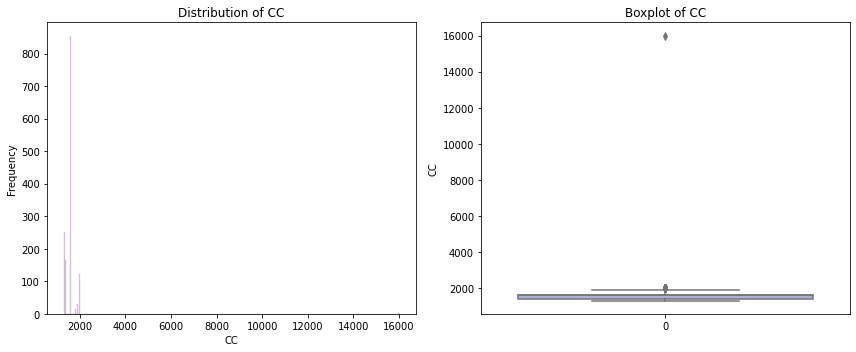

In [121]:
# Set up the subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
sns.histplot(data=toyota['CC'], color='#DEBEE5', ax=axes[0])
axes[0].set_title('Distribution of CC')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('CC')

# Plot the boxplot
sns.boxplot(data=toyota['CC'], color='#A7ABDE', ax=axes[1])
axes[1].set_title('Boxplot of CC')
axes[1].set_ylabel('CC')

# Adjust layout
plt.tight_layout()
plt.show()

In [122]:
toyota[toyota['CC']> 1900]

,Price,Years,KM,Fuel_Type,HP,Automatic,CC,Doors,Gears,Weight,log_KM,log_HP
0,13500.0,23,46986,Diesel,90,0,2000,3,5,1165,10.757626,4.510860
1,13750.0,23,72937,Diesel,90,0,2000,3,5,1165,11.197365,4.510860
2,13950.0,24,41711,Diesel,90,0,2000,3,5,1165,10.638544,4.510860
3,14950.0,26,48000,Diesel,90,0,2000,3,5,1165,10.778977,4.510860
4,13750.0,30,38500,Diesel,90,0,2000,3,5,1170,10.558439,4.510860
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,8750.0,74,89800,Diesel,72,0,2000,3,5,1115,11.405351,4.290459
1202,6950.0,73,88186,Diesel,72,0,2000,3,5,1115,11.387215,4.290459
1216,8500.0,70,85864,Diesel,72,0,2000,5,5,1135,11.360532,4.290459
1320,9400.0,69,67092,Diesel,72,0,2000,3,5,1115,11.113835,4.290459


We have some outlier after the 99th percentile, but we wil only deal with the biggest outlier of this column given above

In [123]:
toyota.loc[toyota['CC'] > 4000, 'CC'] = toyota['CC'].mean()

#### 5. Weight

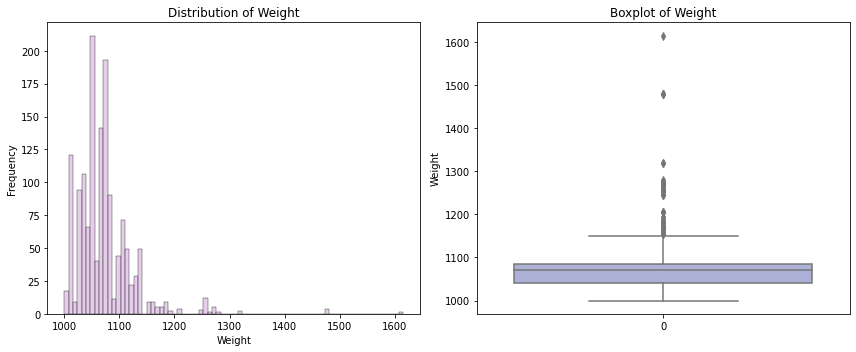

In [124]:
# Set up the subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
sns.histplot(data=toyota['Weight'], color='#DEBEE5', ax=axes[0])
axes[0].set_title('Distribution of Weight')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Weight')

# Plot the boxplot
sns.boxplot(data=toyota['Weight'], color='#A7ABDE', ax=axes[1])
axes[1].set_title('Boxplot of Weight')
axes[1].set_ylabel('Weight')

# Adjust layout
plt.tight_layout()
plt.show()

In [125]:
get_percentile_info(toyota,'Weight',99)


'99 percentile value = 1260.0, there are 19 values above it.'

We will cap the outliers to 99th percentile,as there are only few outliers above 99th percentile andthen create a log of this column to reduce the effect of outliers

In [126]:
p99 = np.percentile(toyota['Weight'], 99)
toyota['Weight'] = toyota['Weight'].apply(lambda x: min(x,p99))

In [127]:
toyota['log_weight'] = np.log1p(toyota['Weight'])

In [128]:
toyota.describe()

,Price,Years,KM,HP,CC,Weight,log_KM,log_HP,log_weight
count,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000
mean,10720.915679,55.980488,68571.782578,101.491986,1566.509799,1071.283624,10.909351,4.619184,6.976660
std,3608.732978,18.563312,37491.094553,14.981408,186.895815,46.081711,1.030964,0.146698,0.041713
min,4350.000000,1.000000,1.000000,69.000000,1300.000000,1000.000000,0.693147,4.248495,6.908755
25%,8450.000000,44.000000,43000.000000,90.000000,1400.000000,1040.000000,10.668979,4.510860,6.947937
50%,9900.000000,61.000000,63451.000000,110.000000,1600.000000,1070.000000,11.058039,4.709530,6.976348
75%,11950.000000,70.000000,87041.500000,110.000000,1600.000000,1085.000000,11.374152,4.709530,6.990257
max,32500.000000,80.000000,243000.000000,192.000000,2000.000000,1260.000000,12.400821,5.262690,7.139660


#### For the remaining cateogorical columns,we will create a bar graph and box plot for each column to check for any patterns.

Note: Instead of using the same plotting code again and again, a function for visualization have been created below

In [129]:
def plot_bar_against_target(dataframe, column, target):
    """
    Plots a bar graph for a specified column against the target column.

    Parameters:
    dataframe (pd.DataFrame): The dataframe containing the data.
    column (str): The column to group by for the bar graph.
    target (str): The target column for aggregation.

    Returns:
    None
    """
    avg_target = dataframe.groupby(column)[target].mean()
    avg_target.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
    plt.title(f'Average {target} by {column}')
    plt.xlabel(column)
    plt.ylabel(f'Average {target}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    
def plot_boxplot_categorical_vs_target(dataframe, categorical_column, target_column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=categorical_column, y=target_column, data=dataframe, palette='Set2')
    plt.title(f'{target_column} Distribution by {categorical_column}')
    plt.xlabel(categorical_column)
    plt.ylabel(target_column)
    plt.xticks(rotation=45)
    plt.show()

#### 6. Doors

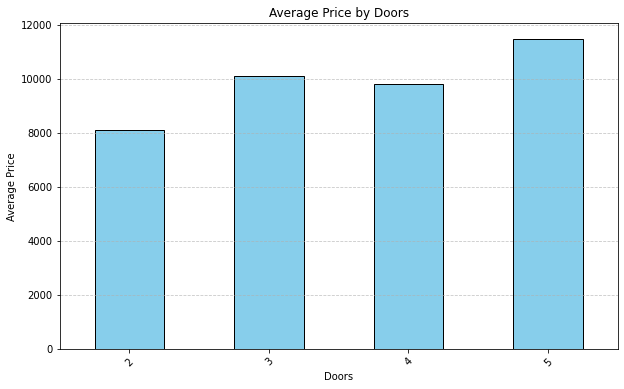

In [130]:
plot_bar_against_target(toyota, 'Doors','Price')

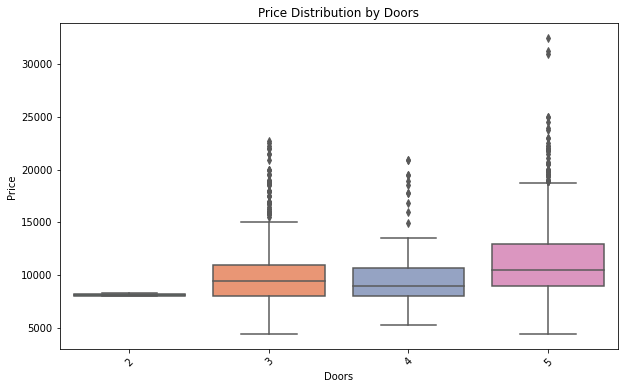

In [131]:
plot_boxplot_categorical_vs_target(toyota, 'Doors','Price')

Price does not have much variarion when number of doors changes. We will not be using this column for our model

#### 7. Gears

In [132]:
toyota['Gears'] = toyota['Gears'].astype('category')

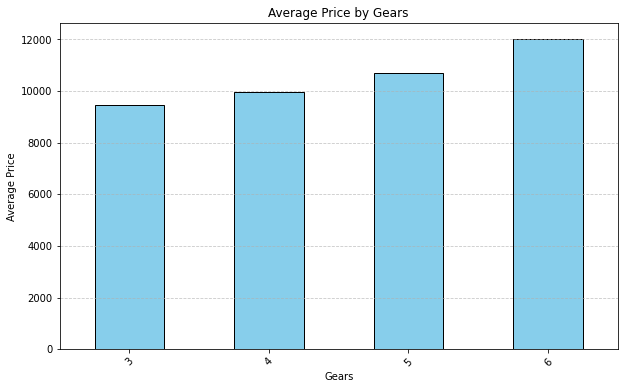

In [133]:
plot_bar_against_target(toyota, 'Gears','Price')

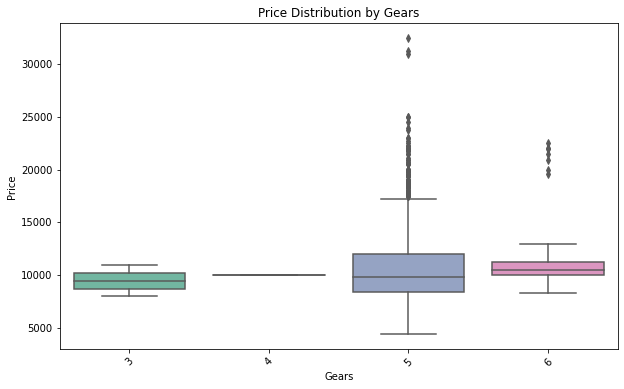

In [134]:
plot_boxplot_categorical_vs_target(toyota, 'Gears','Price')

We see that Price increases as number of gears increases

#### 8. Fuel type

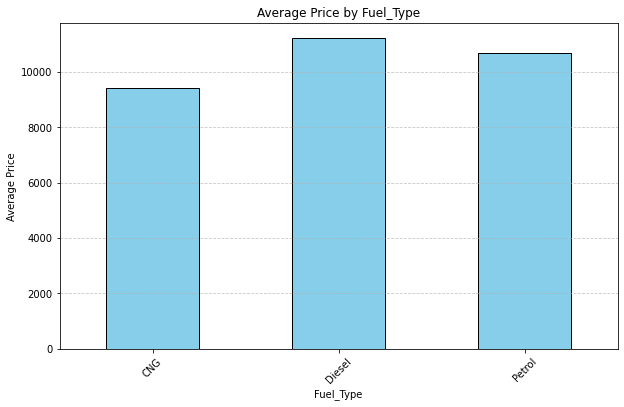

In [135]:
plot_bar_against_target(toyota, 'Fuel_Type','Price')

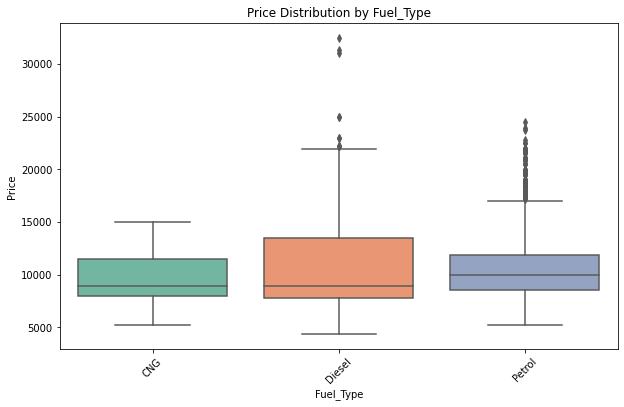

In [136]:
plot_boxplot_categorical_vs_target(toyota, 'Fuel_Type','Price')

Same as Doors, price does not have much variarion with changing Fuel type. We will not be using this column for our model

#### 9. Automatic

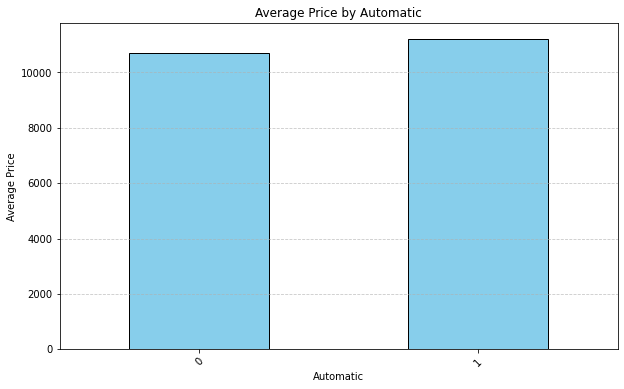

In [137]:
plot_bar_against_target(toyota, 'Automatic','Price')

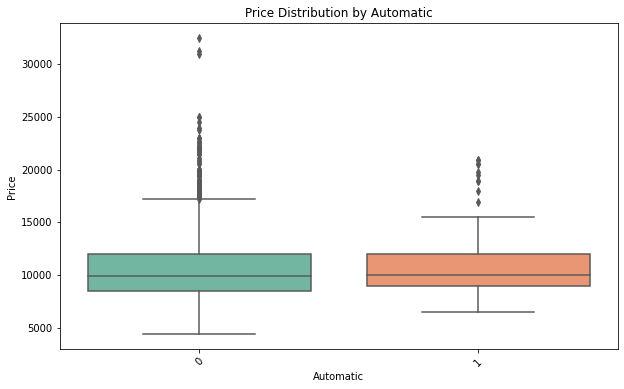

In [138]:
plot_boxplot_categorical_vs_target(toyota, 'Automatic','Price')

We will be skipping this column as well,  due to less effect on the target variable

## 2. Data Visualization and Correlation

We will check the correlation with the target variable and choose the best features.

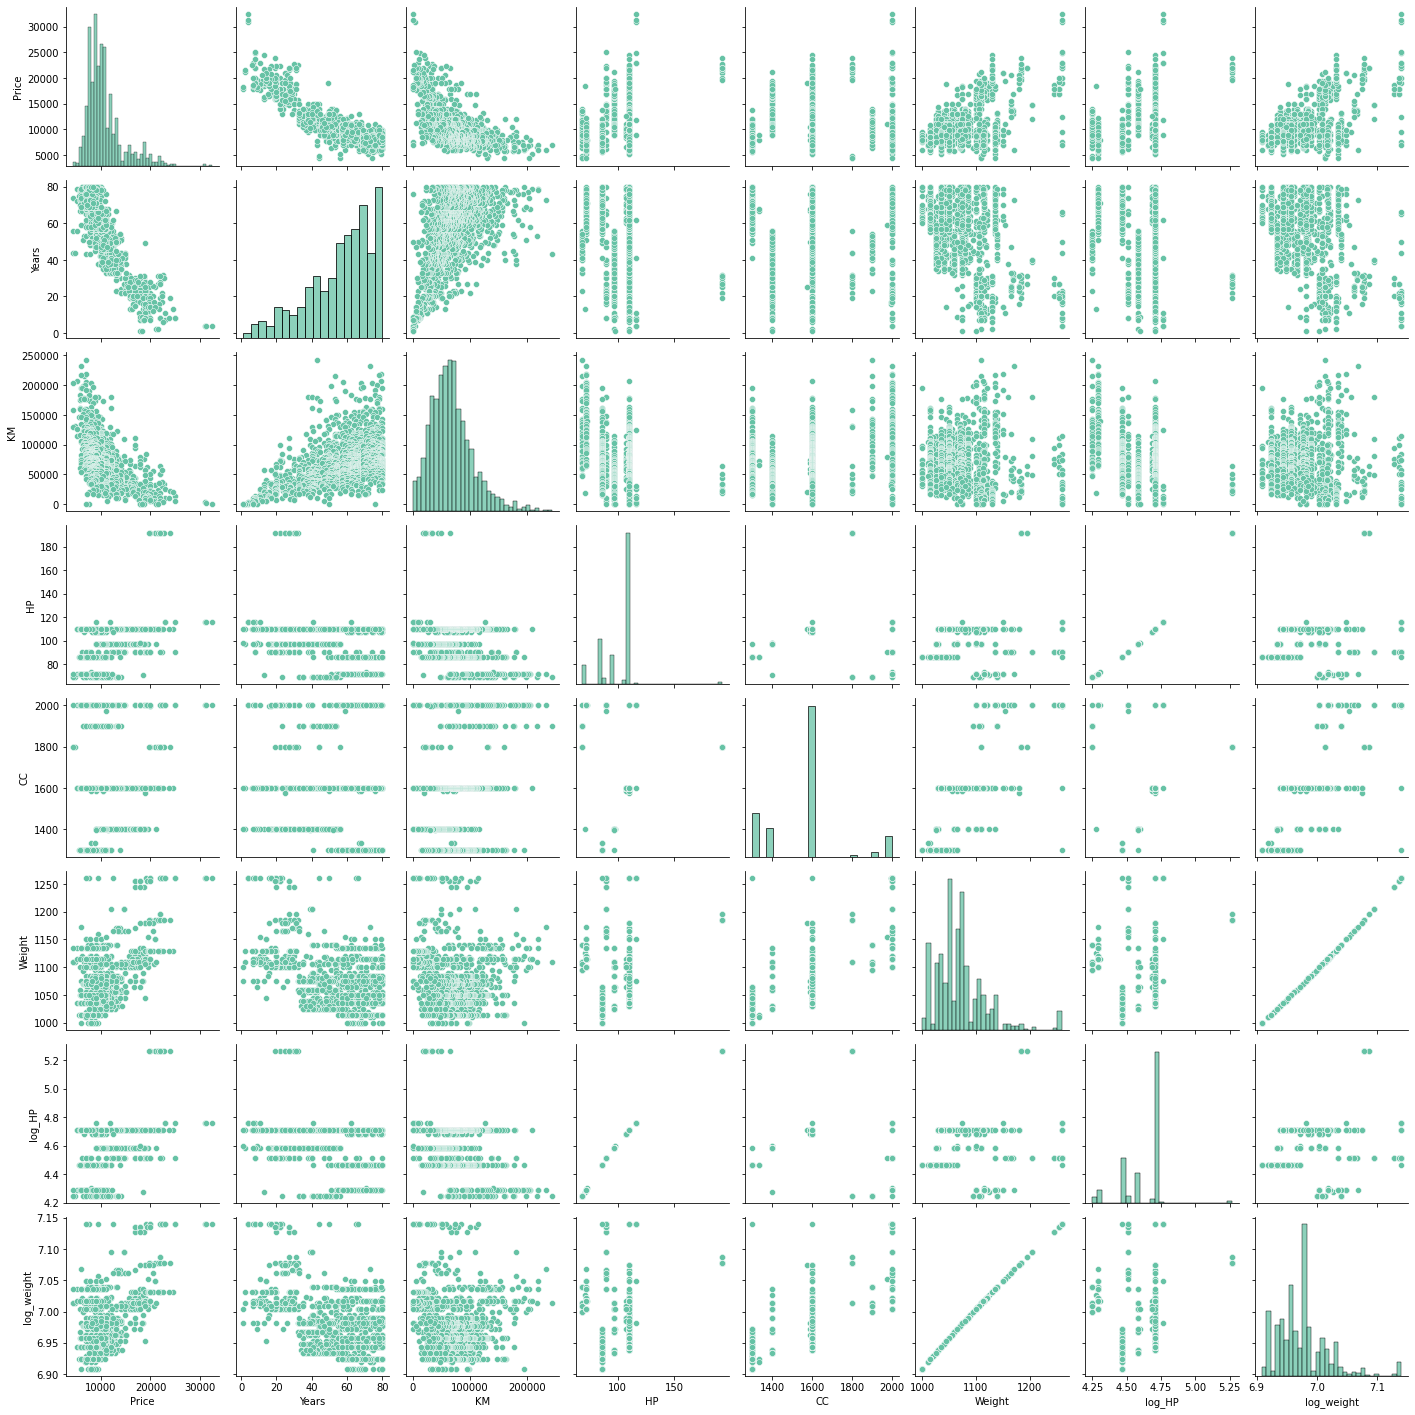

In [139]:
sns. pairplot(data=toyota[['Price','Years','KM','HP','CC','Gears','Weight','log_HP','log_weight']])

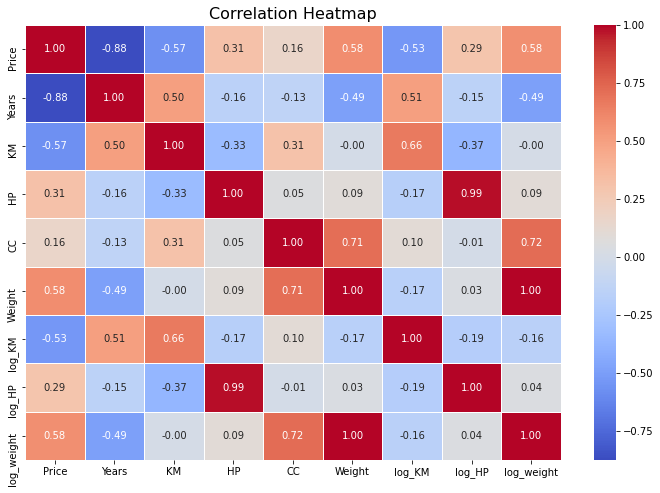

In [140]:


# Assuming 'data' is your DataFrame
plt.figure(figsize=(12, 8))  # Set the figure size
correlation_matrix = toyota.corr()  # Compute the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)

# Add a title for better interpretation
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

We will selected all the columns which has more than 30% correlation to the target variable and keep all the chosen preprocessed data in a separate dataframe for processing. 

Selected columns: 
1. Years
2. Km
3. Weight
4. Gear
5. HP

Columns not used:
1. Automatic
2.Doors
3. Fuel_Type
4.CC
5. Cylinder
6. log_HP
7. log_weight
8. log_KM
    
Log values of HP, Weight and KM does not have much difference in their coefficient correlation values.

In [141]:
# not adding gear column now, as we will include after One Hot Encoding
preprocessed_car_data =pd.DataFrame(toyota[['Years','KM','Weight','HP']])

### Interaction plot

After trying out different combination between two variables, the below plot are interesting variation to include in our models

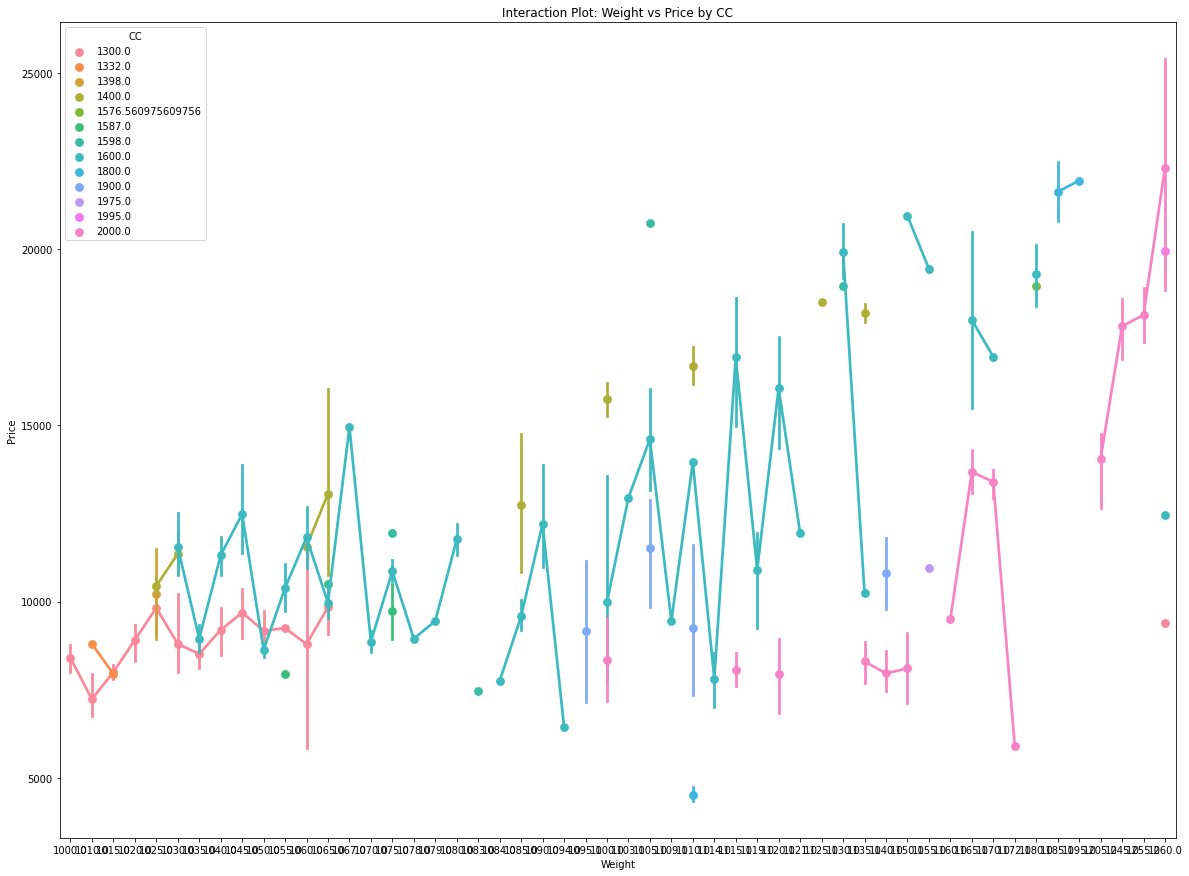

In [142]:
plt.figure(figsize = (20,15))
sns.pointplot(data=toyota, x='Weight', y='Price', hue='CC')
plt.xlabel('Weight')
plt.ylabel('Price')
plt.title('Interaction Plot: Weight vs Price by CC')
plt.show()

+ Non-Parallel:This indicates potential interaction between Weight and CC.
+ Higher Spread at High HP: At higher HP values (beyond ~200), the variability in price increases, and the trends for different CC values diverge more.

Along  with the above combination,we will use some other combination of features derived from domain knowledge like Fuel Efficiency and check the correlation with the target variable

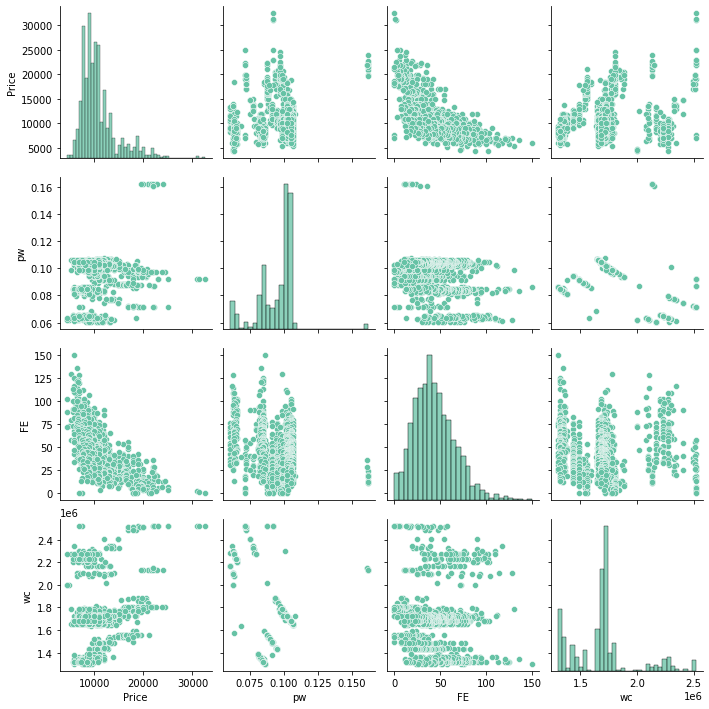

In [143]:

feature_combo =pd.DataFrame()
feature_combo['Price']= toyota['Price']
feature_combo['pw'] = toyota['HP']/ toyota['Weight']
feature_combo['FE'] = toyota['KM']/ toyota['CC']
feature_combo['wc']=toyota['Weight']*toyota['CC']

sns.pairplot(data=feature_combo)

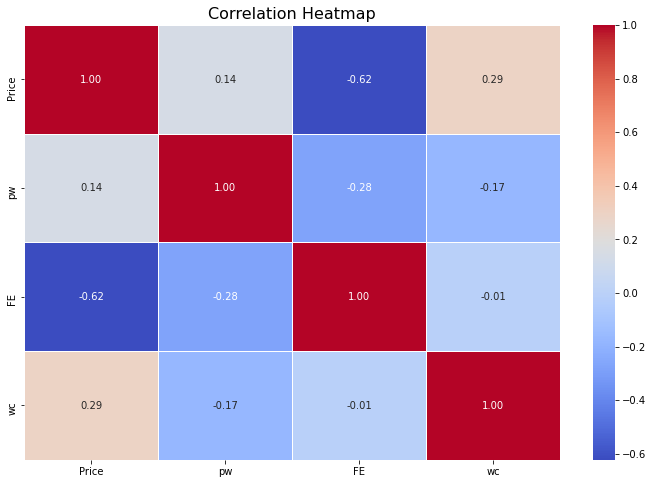

In [144]:
# Assuming 'data' is your DataFrame
plt.figure(figsize=(12, 8))  # Set the figure size
correlation_matrix = feature_combo.corr()  # Compute the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)

# Add a title for better interpretation
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

Combination of KM/CC and have good correlation with the target variable. Weight/CC is also not that bad
We are going to choose the combination of KM and CC, Weight and CC as our other features in the modeling.



In [145]:
preprocessed_car_data['Fuel_Efficiency'] =feature_combo['FE']
preprocessed_car_data['WCC'] = feature_combo['wc']
preprocessed_car_data['pw'] = feature_combo['pw'] 
preprocessed_car_data['FE'] = feature_combo['FE']


In [146]:
preprocessed_car_data.head()

,Years,KM,Weight,HP,Fuel_Efficiency,WCC,pw,FE
0,23,46986,1165.0,90,23.4930,2330000.0,0.077253,23.4930
1,23,72937,1165.0,90,36.4685,2330000.0,0.077253,36.4685
2,24,41711,1165.0,90,20.8555,2330000.0,0.077253,20.8555
3,26,48000,1165.0,90,24.0000,2330000.0,0.077253,24.0000
4,30,38500,1170.0,90,19.2500,2340000.0,0.076923,19.2500


We will be using scaler and train test split for all the modelling, hence we will create a reusable function for both

## 3. Scaling features

In [147]:
scaler = StandardScaler()  # Initialize the scaler
scaled_array = scaler.fit_transform(preprocessed_car_data)  # Scale the DataFrame
scaled_car= pd.DataFrame(scaled_array, columns=preprocessed_car_data.columns)  # Convert back to DataFrame
y = toyota['Price']
y

0       13500.0
1       13750.0
2       13950.0
3       14950.0
4       13750.0
         ...   
1431     7500.0
1432    10845.0
1433     8500.0
1434     7250.0
1435     6950.0
Name: Price, Length: 1435, dtype: float64

In [148]:
scaled_car

,Years,KM,Weight,HP,Fuel_Efficiency,WCC,pw,FE
0,-1.777268,-0.575958,2.034409,-0.767351,-0.900500,2.456662,-1.291150,-0.900500
1,-1.777268,0.116474,2.034409,-0.767351,-0.320996,2.456662,-1.291150,-0.320996
2,-1.723380,-0.716707,2.034409,-0.767351,-1.018295,2.456662,-1.291150,-1.018295
3,-1.615603,-0.548902,2.034409,-0.767351,-0.877857,2.456662,-1.291150,-0.877857
4,-1.400049,-0.802384,2.142950,-0.767351,-1.089999,2.494708,-1.315378,-1.089999
...,...,...,...,...,...,...,...,...
1430,0.701602,-1.281492,-1.004732,-1.034441,-1.243943,-1.338417,-0.803178,-1.243943
1431,0.863267,-1.322689,-1.221813,-1.034441,-1.296987,-1.387877,-0.742514,-1.296987
1432,0.809379,-1.375627,-1.221813,-1.034441,-1.365147,-1.387877,-0.742514,-1.365147
1433,0.755490,-1.378295,-1.221813,-1.034441,-1.368583,-1.387877,-0.742514,-1.368583


We selected

In [149]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
enc_df = pd.DataFrame(enc.fit_transform(toyota[['Gears']]), columns = enc.get_feature_names_out(['Gears']),index =scaled_car.index )     #converting the encoded array into a dataframe
scaled_car = pd.concat([scaled_car, enc_df], axis = 1)  #combine the scaled features dataframe  and the encoded gears dataframe
scaled_car

,Years,KM,Weight,HP,Fuel_Efficiency,WCC,pw,FE,Gears_3,Gears_4,Gears_5,Gears_6
0,-1.777268,-0.575958,2.034409,-0.767351,-0.900500,2.456662,-1.291150,-0.900500,0.0,0.0,1.0,0.0
1,-1.777268,0.116474,2.034409,-0.767351,-0.320996,2.456662,-1.291150,-0.320996,0.0,0.0,1.0,0.0
2,-1.723380,-0.716707,2.034409,-0.767351,-1.018295,2.456662,-1.291150,-1.018295,0.0,0.0,1.0,0.0
3,-1.615603,-0.548902,2.034409,-0.767351,-0.877857,2.456662,-1.291150,-0.877857,0.0,0.0,1.0,0.0
4,-1.400049,-0.802384,2.142950,-0.767351,-1.089999,2.494708,-1.315378,-1.089999,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1430,0.701602,-1.281492,-1.004732,-1.034441,-1.243943,-1.338417,-0.803178,-1.243943,0.0,0.0,1.0,0.0
1431,0.863267,-1.322689,-1.221813,-1.034441,-1.296987,-1.387877,-0.742514,-1.296987,0.0,0.0,1.0,0.0
1432,0.809379,-1.375627,-1.221813,-1.034441,-1.365147,-1.387877,-0.742514,-1.365147,0.0,0.0,1.0,0.0
1433,0.755490,-1.378295,-1.221813,-1.034441,-1.368583,-1.387877,-0.742514,-1.368583,0.0,0.0,1.0,0.0


## 4. Train Test Split

We will split the dataset into training(80%) and testing(20%) dataset and use the same for each model.

In [150]:
X_train, X_test, y_train, y_test = train_test_split(scaled_car, y, train_size=0.8, random_state = 42)

In [151]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1148, 12)
(1148,)
(287, 12)
(287,)


## 5. Modeling

For all the models, we will be using the following metrics to evaluate the model:

1. MSE(Mean Squared Error)
2. R squared
3. Adjacent R squared


We will insert all the Metrics in a dataframe called "evaluation" for better readability

### Model 1

Our first model will be a simple model with few features.  We will use the selected features from the dataset and the two combination feature which had the high correlation score: Fuel_Efficiency and WCC

We will first build a model based on the data we have processed and look into the way the feature behaves for this model, and we wiill try to achieve better results but tweaking the features in the subsequent models

In [152]:
model_1_X_train = X_train[['Years','KM','Weight','HP','Fuel_Efficiency','WCC','Gears_3','Gears_4','Gears_5','Gears_6']]
model_1_X_test = X_test[['Years','KM','Weight','HP','Fuel_Efficiency','WCC','Gears_3','Gears_4','Gears_5','Gears_6']]


In [153]:
evaluation = pd.DataFrame(columns=['RMSE Train','R squared Train','Adj. R squared Train', 'RMSE Test','R squared Test','Adj. R squared Test'])

In [154]:
model_1 = LinearRegression()
model_1.fit(model_1_X_train, y_train)

LinearRegression()

In [155]:
y_train_pred = model_1.predict(model_1_X_train)
y_test_pred =model_1.predict(model_1_X_test)


In [156]:

mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

n = X_train.shape[0]
k = X_train.shape[1]
adjr2 = 1 - (( 1 - r2) * (n - 1)/(n - k - 1))

print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")
print(f" Adjusted R-squared: {adjr2}")

ev =[np.sqrt(mse),r2,adjr2]

Root Mean Squared Error: 1310.6257877752396
R-squared: 0.870533922712267
 Adjusted R-squared: 0.8691651183708989


In [157]:

mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

n = X_test.shape[0]
k = X_test.shape[1]
adjr2 = 1 - (( 1 - r2) * (n - 1)/(n - k - 1))

print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")
print(f" Adjusted R-squared: {adjr2}")

ev.extend([np.sqrt(mse),r2,adjr2])
evaluation.loc[0]= ev
evaluation.head()

Root Mean Squared Error: 1290.737085047022
R-squared: 0.8611333128058718
 Adjusted R-squared: 0.8550515600820414


,RMSE Train,R squared Train,Adj. R squared Train,RMSE Test,R squared Test,Adj. R squared Test
0,1310.625788,0.870534,0.869165,1290.737085,0.861133,0.855052


In [158]:
model_1_X_train.head()

,Years,KM,Weight,HP,Fuel_Efficiency,WCC,Gears_3,Gears_4,Gears_5,Gears_6
1127,1.186598,1.085735,-0.027865,0.568103,1.100170,0.105425,0.0,0.0,1.0,0.0
898,0.324382,-0.247526,-0.787650,-1.034441,0.087345,-1.288957,0.0,0.0,1.0,0.0
1187,0.809379,0.581627,-0.787650,-1.034441,1.154925,-1.288957,0.0,0.0,1.0,0.0
310,-0.645610,-0.803425,0.189216,0.568103,-0.876154,0.166298,0.0,0.0,1.0,0.0
1144,1.024933,0.888073,-0.027865,0.568103,0.893387,0.105425,0.0,0.0,1.0,0.0


In [159]:
model_1_X_train["Price"] =y_train
model = smf.ols('Price ~ Years + Weight + KM + Fuel_Efficiency + WCC+ HP+Gears_3+Gears_4+Gears_5+Gears_6 ', data=model_1_X_train).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     547.1
Date:                Fri, 24 Jan 2025   Prob (F-statistic):               0.00
Time:                        01:05:09   Log-Likelihood:                -8165.9
No. Observations:                 930   AIC:                         1.635e+04
Df Residuals:                     921   BIC:                         1.639e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -8.899e+15    1.1e+16     -0.808      0.419   -3.05e+16    1.27e+16
Years           -2341.8738     75.951    -30.834      0.000   -2490.930   -2192.817
Weight           1056.3585    126.139      8.375      0.000     808.805    1303.912
KM              -1964.9133    378.359     -5.193      0.000   -2707.459   -1222.367
Fuel_Efficiency  1298.7341    353.411      3.675      0.000     605.150    1992.318
WCC              -150.2293    173.808     -0.864      0.388    -491.336     190.877
HP                325.0388     56.776      5.725      0.000     213.613     436.464
Gears_3          8.899e+15    1.1e+16      0.808      0.419   -1.27e+16    3.05e+16
Gears_4         -1.414e+12   1.75e+12     -0.808      0.419   -4.85e+12    2.02e+12
Gears_5          8.899e+15    1.1e+16      0.808      0.419   -1.27e+16    3.05e+16
Gears_6          8.899e+15    1.1e+16      0.808      0.419   -1.27e+16    3.05e+16
==============================================================================
Omnibus:                      122.727   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              570.646
Skew:                           0.514   Prob(JB):                    1.22e-124
Kurtosis:                       6.697   Cond. No.                     2.89e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.25e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We tried and test the following with the above model, but the above model worked best:
1. Removed HP
2. Removed Gears
2. Incorporated Automatic column



In [160]:
#removing target from X_train
model_1_X_train.pop('Price')
model_1_X_train.head()

,Years,KM,Weight,HP,Fuel_Efficiency,WCC,Gears_3,Gears_4,Gears_5,Gears_6
1127,1.186598,1.085735,-0.027865,0.568103,1.100170,0.105425,0.0,0.0,1.0,0.0
898,0.324382,-0.247526,-0.787650,-1.034441,0.087345,-1.288957,0.0,0.0,1.0,0.0
1187,0.809379,0.581627,-0.787650,-1.034441,1.154925,-1.288957,0.0,0.0,1.0,0.0
310,-0.645610,-0.803425,0.189216,0.568103,-0.876154,0.166298,0.0,0.0,1.0,0.0
1144,1.024933,0.888073,-0.027865,0.568103,0.893387,0.105425,0.0,0.0,1.0,0.0


### Model 2

<b>In our 2nd model, we will make use of the remaining feature_combo dataset and use the features that we didn't choose for our previous model to check if the model performs any better.</b>

We are testing if increasing the complexity or number of features, increases the r2 or decrease Adjacent rsquared significantly or not.


In [161]:
X_train.head()

,Years,KM,Weight,HP,Fuel_Efficiency,WCC,pw,FE,Gears_3,Gears_4,Gears_5,Gears_6
1127,1.186598,1.085735,-0.027865,0.568103,1.100170,0.105425,0.583946,1.100170,0.0,0.0,1.0,0.0
898,0.324382,-0.247526,-0.787650,-1.034441,0.087345,-1.288957,-0.862670,0.087345,0.0,0.0,1.0,0.0
1187,0.809379,0.581627,-0.787650,-1.034441,1.154925,-1.288957,-0.862670,1.154925,0.0,0.0,1.0,0.0
310,-0.645610,-0.803425,0.189216,0.568103,-0.876154,0.166298,0.514089,-0.876154,0.0,0.0,1.0,0.0
1144,1.024933,0.888073,-0.027865,0.568103,0.893387,0.105425,0.583946,0.893387,0.0,0.0,1.0,0.0


In [162]:
model_2_X_train =X_train.copy()
model_2_X_test =X_test.copy()

In [163]:
model_2 = LinearRegression()
model_2.fit(model_2_X_train, y_train)

LinearRegression()

In [164]:
y_train_pred = model_2.predict(model_2_X_train)
y_test_pred =model_2.predict(model_2_X_test)

In [165]:

mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

n = X_train.shape[0]
k = X_train.shape[1]
adjr2 = 1 - (( 1 - r2) * (n - 1)/(n - k - 1))

print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")
print(f" Adjusted R-squared: {adjr2}")

ev =[np.sqrt(mse),r2,adjr2]

Root Mean Squared Error: 1289.3459599028383
R-squared: 0.8747039155712708
 Adjusted R-squared: 0.8733791992601301


In [166]:

mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

n = X_test.shape[0]
k = X_test.shape[1]
adjr2 = 1 - (( 1 - r2) * (n - 1)/(n - k - 1))

print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")
print(f" Adjusted R-squared: {adjr2}")

ev.extend([np.sqrt(mse),r2,adjr2])
evaluation.loc[1]= ev
evaluation.head()

Root Mean Squared Error: 1251.3133444752386
R-squared: 0.8694867360951395
 Adjusted R-squared: 0.8637708267270434


,RMSE Train,R squared Train,Adj. R squared Train,RMSE Test,R squared Test,Adj. R squared Test
0,1310.625788,0.870534,0.869165,1290.737085,0.861133,0.855052
1,1289.345960,0.874704,0.873379,1251.313344,0.869487,0.863771


In [167]:
model_2_X_train["Price"] =y_train
model = smf.ols('Price ~ Years + Weight + KM + Fuel_Efficiency + WCC+ HP+pw+FE+Gears_3+Gears_4+Gears_5+Gears_6 ', data=model_2_X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     502.9
Date:                Fri, 24 Jan 2025   Prob (F-statistic):               0.00
Time:                        01:05:10   Log-Likelihood:                -8152.6
No. Observations:                 930   AIC:                         1.633e+04
Df Residuals:                     920   BIC:                         1.637e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.065e+16   1.19e+16      0.892      0.373   -1.28e+16    3.41e+16
Years           -2329.3752     75.243    -30.958      0.000   -2477.044   -2181.706
Weight           -495.1459    347.545     -1.425      0.155   -1177.220     186.928
KM              -1909.9220    373.128     -5.119      0.000   -2642.203   -1177.641
Fuel_Efficiency -1.962e+13    2.2e+13     -0.892      0.373   -6.28e+13    2.36e+13
WCC                43.8048    176.184      0.249      0.804    -301.965     389.574
HP               5311.0926   1048.239      5.067      0.000    3253.875    7368.310
pw              -5079.2767   1066.119     -4.764      0.000   -7171.585   -2986.968
FE               1.962e+13    2.2e+13      0.892      0.373   -2.36e+13    6.28e+13
Gears_3         -1.065e+16   1.19e+16     -0.892      0.373   -3.41e+16    1.28e+16
Gears_4         -2220.1913   2490.339     -0.892      0.373   -7107.596    2667.213
Gears_5         -1.065e+16   1.19e+16     -0.892      0.373   -3.41e+16    1.28e+16
Gears_6         -1.065e+16   1.19e+16     -0.892      0.373   -3.41e+16    1.28e+16
==============================================================================
Omnibus:                      114.314   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              565.270
Skew:                           0.443   Prob(JB):                    1.79e-123
Kurtosis:                       6.715   Cond. No.                     3.66e+29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.75e-56. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The small change in the features didnot impact the performance in a big level. Hence, we will increase the complexity of the model for our next model
In the following models, we will not be using the stats model as we are going to increase the number of features. 

### Model 3

<b>As we did not see greater performance difference in our second model, we will use the our features from the first model and make polynomial features with degree 2 and test if the model performs much better.</b>

We will not be using "Gears" feature in the upcoming modelling because it doesn't add any special value

In [168]:
scaled_car.pop('Gears_3')
scaled_car.pop('Gears_4')
scaled_car.pop('Gears_5')
scaled_car.pop('Gears_6')
scaled_car.pop('pw')
scaled_car.pop('FE')
scaled_car.head()

,Years,KM,Weight,HP,Fuel_Efficiency,WCC
0,-1.777268,-0.575958,2.034409,-0.767351,-0.900500,2.456662
1,-1.777268,0.116474,2.034409,-0.767351,-0.320996,2.456662
2,-1.723380,-0.716707,2.034409,-0.767351,-1.018295,2.456662
3,-1.615603,-0.548902,2.034409,-0.767351,-0.877857,2.456662
4,-1.400049,-0.802384,2.142950,-0.767351,-1.089999,2.494708


In [169]:
poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(scaled_car)
poly_features_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(scaled_car.columns))

# Drop the first column (bias term)
poly_features_df = poly_features_df.iloc[:, 1:]
poly_features_df.head()

,Years,KM,Weight,HP,Fuel_Efficiency,WCC,Years^2,Years KM,Years Weight,Years HP,...,Weight^2,Weight HP,Weight Fuel_Efficiency,Weight WCC,HP^2,HP Fuel_Efficiency,HP WCC,Fuel_Efficiency^2,Fuel_Efficiency WCC,WCC^2
0,-1.777268,-0.575958,2.034409,-0.767351,-0.900500,2.456662,3.158682,1.023632,-3.615691,1.363788,...,4.138820,-1.561105,-1.831986,4.997854,0.588827,0.690999,-1.885121,0.810901,-2.212224,6.035186
1,-1.777268,0.116474,2.034409,-0.767351,-0.320996,2.456662,3.158682,-0.207006,-3.615691,1.363788,...,4.138820,-1.561105,-0.653037,4.997854,0.588827,0.246316,-1.885121,0.103038,-0.788578,6.035186
2,-1.723380,-0.716707,2.034409,-0.767351,-1.018295,2.456662,2.970038,1.235159,-3.506059,1.322437,...,4.138820,-1.561105,-2.071628,4.997854,0.588827,0.781389,-1.885121,1.036924,-2.501606,6.035186
3,-1.615603,-0.548902,2.034409,-0.767351,-0.877857,2.456662,2.610173,0.886808,-3.286797,1.239734,...,4.138820,-1.561105,-1.785920,4.997854,0.588827,0.673624,-1.885121,0.770633,-2.156597,6.035186
4,-1.400049,-0.802384,2.142950,-0.767351,-1.089999,2.494708,1.960137,1.123377,-3.000234,1.074328,...,4.592234,-1.644394,-2.335812,5.346033,0.588827,0.836411,-1.914315,1.188097,-2.719228,6.223566


Using this many features, just for predicting the car price does not make sense.<br>
We have to select the most important features among the polynomials and only use that features to predict the Price.

<b>We will use regularization technique: Lasso for selecting the important features</b>

In [170]:


# Initialize Lasso with cross-validation
lasso = LassoCV(cv=5, random_state=42)

# Fit Lasso to your polynomial features
lasso.fit(poly_features_df, y)

# Get coefficients
coefficients = lasso.coef_

# Identify important features (non-zero coefficients)
important_features = [i for i, coef in enumerate(coefficients) if coef != 0]

print(f"Selected features (indices): {important_features}")

Selected features (indices): [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 26]


In [171]:
for i, coef in enumerate(coefficients):
    if( coef!=0):
        print( coef,":::", poly_features_df.columns[i])

-1937.5805215565463 ::: Years
-567.639609630263 ::: KM
800.5109686845692 ::: Weight
209.33486827835068 ::: HP
-1.89181011931731 ::: Fuel_Efficiency
22.23298350815561 ::: Years^2
707.0176415420308 ::: Years KM
-585.2262138827482 ::: Years Weight
-255.66972695374596 ::: Years HP
-360.7508099459161 ::: Years Fuel_Efficiency
-29.63269127300058 ::: Years WCC
-26.89373553853396 ::: KM^2
9.597616487522494 ::: KM Weight
-57.086522642762745 ::: KM HP
-96.50020394018941 ::: KM Fuel_Efficiency
-93.01967853763864 ::: Weight^2
170.30804509745812 ::: Weight HP
27.728920104084047 ::: Weight Fuel_Efficiency
-4.799265983458755 ::: Weight WCC
-75.4017837623284 ::: HP^2
-44.2476212661482 ::: WCC^2


<b>We will incorporate only the features above to our Model 1 features</b>

In [172]:
model3 = pd.DataFrame([])
for i, coef in enumerate(coefficients):
    if( coef!=0):
        model3[poly_features_df.columns[i]]=poly_features_df[poly_features_df.columns[i]]
model3

,Years,KM,Weight,HP,Fuel_Efficiency,Years^2,Years KM,Years Weight,Years HP,Years Fuel_Efficiency,...,KM^2,KM Weight,KM HP,KM Fuel_Efficiency,Weight^2,Weight HP,Weight Fuel_Efficiency,Weight WCC,HP^2,WCC^2
0,-1.777268,-0.575958,2.034409,-0.767351,-0.900500,3.158682,1.023632,-3.615691,1.363788,1.600430,...,0.331728,-1.171735,0.441962,0.518651,4.138820,-1.561105,-1.831986,4.997854,0.588827,6.035186
1,-1.777268,0.116474,2.034409,-0.767351,-0.320996,3.158682,-0.207006,-3.615691,1.363788,0.570496,...,0.013566,0.236956,-0.089376,-0.037388,4.138820,-1.561105,-0.653037,4.997854,0.588827,6.035186
2,-1.723380,-0.716707,2.034409,-0.767351,-1.018295,2.970038,1.235159,-3.506059,1.322437,1.754909,...,0.513670,-1.458076,0.549966,0.729819,4.138820,-1.561105,-2.071628,4.997854,0.588827,6.035186
3,-1.615603,-0.548902,2.034409,-0.767351,-0.877857,2.610173,0.886808,-3.286797,1.239734,1.418268,...,0.301294,-1.116692,0.421201,0.481858,4.138820,-1.561105,-1.785920,4.997854,0.588827,6.035186
4,-1.400049,-0.802384,2.142950,-0.767351,-1.089999,1.960137,1.123377,-3.000234,1.074328,1.526051,...,0.643821,-1.719469,0.615710,0.874598,4.592234,-1.644394,-2.335812,5.346033,0.588827,6.223566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,0.701602,-1.281492,-1.004732,-1.034441,-1.243943,0.492245,-0.899097,-0.704921,-0.725766,-0.872753,...,1.642221,1.287555,1.325628,1.594103,1.009486,1.039336,1.249829,1.344750,1.070069,1.791360
1431,0.863267,-1.322689,-1.221813,-1.034441,-1.296987,0.745230,-1.141834,-1.054751,-0.892999,-1.119646,...,1.749507,1.616079,1.368244,1.715511,1.492828,1.263894,1.584676,1.695726,1.070069,1.926202
1432,0.809379,-1.375627,-1.221813,-1.034441,-1.365147,0.655094,-1.113403,-0.988910,-0.837255,-1.104921,...,1.892349,1.680759,1.423005,1.877933,1.492828,1.263894,1.667955,1.695726,1.070069,1.926202
1433,0.755490,-1.378295,-1.221813,-1.034441,-1.368583,0.570765,-1.041288,-0.923068,-0.781510,-1.033951,...,1.899697,1.684019,1.425765,1.886311,1.492828,1.263894,1.672153,1.695726,1.070069,1.926202


In [173]:
X_train, X_test, y_train, y_test = train_test_split(model3, y, train_size=0.8, random_state = 42)

In [174]:
model_3 = LinearRegression()
model_3.fit(X_train, y_train)

LinearRegression()

In [175]:
y_train_pred = model_3.predict(X_train)
y_test_pred =model_3.predict(X_test)

In [176]:
model3_ypred= y_test_pred.copy()

In [177]:

mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

n = X_train.shape[0]
k = X_train.shape[1]
adjr2 = 1 - (( 1 - r2) * (n - 1)/(n - k - 1))

print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")
print(f" Adjusted R-squared: {adjr2}")

ev =[np.sqrt(mse),r2,adjr2]

Root Mean Squared Error: 1097.98707490682
R-squared: 0.9091357539563137
 Adjusted R-squared: 0.9074411276979502


In [178]:

mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

n = X_test.shape[0]
k = X_test.shape[1]
adjr2 = 1 - (( 1 - r2) * (n - 1)/(n - k - 1))

print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")
print(f" Adjusted R-squared: {adjr2}")

ev.extend([np.sqrt(mse),r2,adjr2])
evaluation.loc[2]= ev
evaluation.head()

Root Mean Squared Error: 1176.7276034758163
R-squared: 0.8845817776879439
 Adjusted R-squared: 0.8754354279952904


,RMSE Train,R squared Train,Adj. R squared Train,RMSE Test,R squared Test,Adj. R squared Test
0,1310.625788,0.870534,0.869165,1290.737085,0.861133,0.855052
1,1289.345960,0.874704,0.873379,1251.313344,0.869487,0.863771
2,1097.987075,0.909136,0.907441,1176.727603,0.884582,0.875435


### Model 4

<b>Using similar approach of model 3, we will use the our features from the first model and make polynomial features with degree 3 and test if the model performs even better. This will be our last model, any more complexities will just overfit data and the problem is not that complex to require that level of complexity</b>

In [179]:
scaled_car.head()

,Years,KM,Weight,HP,Fuel_Efficiency,WCC
0,-1.777268,-0.575958,2.034409,-0.767351,-0.900500,2.456662
1,-1.777268,0.116474,2.034409,-0.767351,-0.320996,2.456662
2,-1.723380,-0.716707,2.034409,-0.767351,-1.018295,2.456662
3,-1.615603,-0.548902,2.034409,-0.767351,-0.877857,2.456662
4,-1.400049,-0.802384,2.142950,-0.767351,-1.089999,2.494708


In [180]:
poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(scaled_car)
poly_features_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(scaled_car.columns))

# Drop the first column (bias term)
poly_features_df = poly_features_df.iloc[:, 1:]
poly_features_df.head()

,Years,KM,Weight,HP,Fuel_Efficiency,WCC,Years^2,Years KM,Years Weight,Years HP,...,HP^3,HP^2 Fuel_Efficiency,HP^2 WCC,HP Fuel_Efficiency^2,HP Fuel_Efficiency WCC,HP WCC^2,Fuel_Efficiency^3,Fuel_Efficiency^2 WCC,Fuel_Efficiency WCC^2,WCC^3
0,-1.777268,-0.575958,2.034409,-0.767351,-0.900500,2.456662,3.158682,1.023632,-3.615691,1.363788,...,-0.451837,-0.530239,1.446549,-0.622245,1.697552,-4.631104,-0.730216,1.992109,-5.434687,14.826411
1,-1.777268,0.116474,2.034409,-0.767351,-0.320996,2.456662,3.158682,-0.207006,-3.615691,1.363788,...,-0.451837,-0.189011,1.446549,-0.079067,0.605116,-4.631104,-0.033075,0.253130,-1.937270,14.826411
2,-1.723380,-0.716707,2.034409,-0.767351,-1.018295,2.456662,2.970038,1.235159,-3.506059,1.322437,...,-0.451837,-0.599599,1.446549,-0.795684,1.919609,-4.631104,-1.055894,2.547372,-6.145599,14.826411
3,-1.615603,-0.548902,2.034409,-0.767351,-0.877857,2.456662,2.610173,0.886808,-3.286797,1.239734,...,-0.451837,-0.516906,1.446549,-0.591345,1.654866,-4.631104,-0.676505,1.893184,-5.298030,14.826411
4,-1.400049,-0.802384,2.142950,-0.767351,-1.089999,2.494708,1.960137,1.123377,-3.000234,1.074328,...,-0.451837,-0.641821,1.468951,-0.911687,2.086601,-4.775657,-1.295024,2.963955,-6.783678,15.525976


In [181]:

# Initialize Lasso with cross-validation
lasso = LassoCV(cv=5, random_state=42)

# Fit Lasso to your polynomial features
lasso.fit(poly_features_df, y)

# Get coefficients
coefficients = lasso.coef_

# Identify important features (non-zero coefficients)
important_features = [i for i, coef in enumerate(coefficients) if coef != 0]

print(f"Selected features (indices): {important_features}")

Selected features (indices): [0, 2, 4, 6, 9, 10, 26, 27, 29, 38, 48, 51, 56, 57, 64, 73, 75, 78, 82]


In [182]:
model4 = pd.DataFrame([])
for i, coef in enumerate(coefficients):
    if( coef!=0):
        model4[poly_features_df.columns[i]]=poly_features_df[poly_features_df.columns[i]]
model4

,Years,Weight,Fuel_Efficiency,Years^2,Years HP,Years Fuel_Efficiency,WCC^2,Years^3,Years^2 Weight,Years Weight^2,KM^3,KM^2 Fuel_Efficiency,KM Weight WCC,KM HP^2,Weight^2 HP,HP^3,HP^2 WCC,HP WCC^2,WCC^3
0,-1.777268,2.034409,-0.900500,3.158682,1.363788,1.600430,6.035186,-5.613826,6.426052,-7.355793,-0.191061,-0.298721,-2.878556,-0.339140,-3.175926,-0.451837,1.446549,-4.631104,14.826411
1,-1.777268,2.034409,-0.320996,3.158682,1.363788,0.570496,6.035186,-5.613826,6.426052,-7.355793,0.001580,-0.004355,0.582120,0.068583,-3.175926,-0.451837,1.446549,-4.631104,14.826411
2,-1.723380,2.034409,-1.018295,2.970038,1.322437,1.754909,6.035186,-5.118503,6.042272,-7.132759,-0.368151,-0.523067,-3.582000,-0.422017,-3.175926,-0.451837,1.446549,-4.631104,14.826411
3,-1.615603,2.034409,-0.877857,2.610173,1.239734,1.418268,6.035186,-4.217002,5.310158,-6.686689,-0.165381,-0.264493,-2.743335,-0.323209,-3.175926,-0.451837,1.446549,-4.631104,14.826411
4,-1.400049,2.142950,-1.089999,1.960137,1.074328,1.526051,6.223566,-2.744288,4.200475,-6.429352,-0.516592,-0.701764,-4.289573,-0.472466,-3.523853,-0.451837,1.468951,-4.775657,15.525976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,0.701602,-1.004732,-1.243943,0.492245,-0.725766,-0.872753,1.791360,0.345360,-0.494574,0.708257,-2.104492,-2.042829,-1.723286,-1.371284,-1.044254,-1.106923,-1.432198,-1.853057,-2.397587
1431,0.863267,-1.221813,-1.296987,0.745230,-0.892999,-1.119646,1.926202,0.643333,-0.910532,1.288709,-2.314053,-2.269088,-2.242919,-1.415368,-1.544243,-1.106923,-1.485124,-1.992543,-2.673331
1432,0.809379,-1.221813,-1.365147,0.655094,-0.837255,-1.104921,1.926202,0.530219,-0.800402,1.208263,-2.603166,-2.583336,-2.332687,-1.472015,-1.544243,-1.106923,-1.485124,-1.992543,-2.673331
1433,0.755490,-1.221813,-1.368583,0.570765,-0.781510,-1.033951,1.926202,0.431208,-0.697369,1.127817,-2.618343,-2.599893,-2.337211,-1.474871,-1.544243,-1.106923,-1.485124,-1.992543,-2.673331


In [183]:
X_train, X_test, y_train, y_test = train_test_split(model4, y, train_size=0.8, random_state = 42)

In [184]:
model_4 = LinearRegression()
model_4.fit(X_train, y_train)

LinearRegression()

In [185]:
y_train_pred = model_4.predict(X_train)
y_test_pred =model_4.predict(X_test)

In [186]:

mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

n = X_train.shape[0]
k = X_train.shape[1]
adjr2 = 1 - (( 1 - r2) * (n - 1)/(n - k - 1))

print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")
print(f" Adjusted R-squared: {adjr2}")

ev =[np.sqrt(mse),r2,adjr2]

Root Mean Squared Error: 1088.356110441126
R-squared: 0.910722789616887
 Adjusted R-squared: 0.9092190068178807


In [187]:

mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

n = X_test.shape[0]
k = X_test.shape[1]
adjr2 = 1 - (( 1 - r2) * (n - 1)/(n - k - 1))

print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")
print(f" Adjusted R-squared: {adjr2}")

ev.extend([np.sqrt(mse),r2,adjr2])
evaluation.loc[3]= ev
evaluation.head()

Root Mean Squared Error: 1234.1117467241888
R-squared: 0.8730503608302114
 Adjusted R-squared: 0.8640164913761814


,RMSE Train,R squared Train,Adj. R squared Train,RMSE Test,R squared Test,Adj. R squared Test
0,1310.625788,0.870534,0.869165,1290.737085,0.861133,0.855052
1,1289.345960,0.874704,0.873379,1251.313344,0.869487,0.863771
2,1097.987075,0.909136,0.907441,1176.727603,0.884582,0.875435
3,1088.356110,0.910723,0.909219,1234.111747,0.873050,0.864016


#### After comparing the errors and r square value of all the models, Model 3 seems to be best out of all four. The following points led to the final decision:

1. R square for training data is 91% and testing data is 88.5%.The result of training and testing data does not have much difference.
2.RMSE is also less compared to the other models
3. Even  though Model 4 gives less RMSE and good Rsquare value, Adjacent R square is decreased compared to model 3.Hence, model 4 is not as good as Model 3
4.Adj.R square is good for model 3 compared to other models

We will finally end our analysis with Residual Analysis to check all three conditions are met.

### Residual Analysis

In [188]:
residuals = y_test - model3_ypred

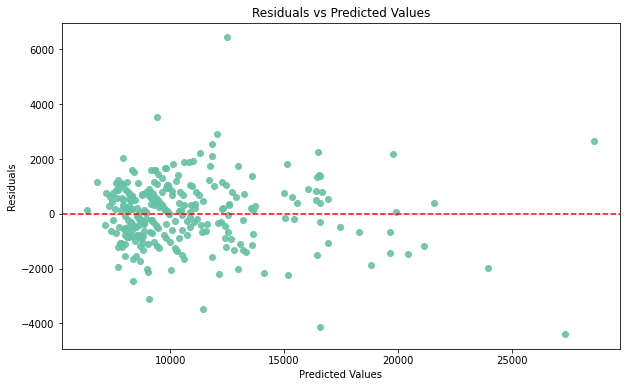

In [189]:
# Residuals vs. Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(model3_ypred, residuals, alpha=0.9)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

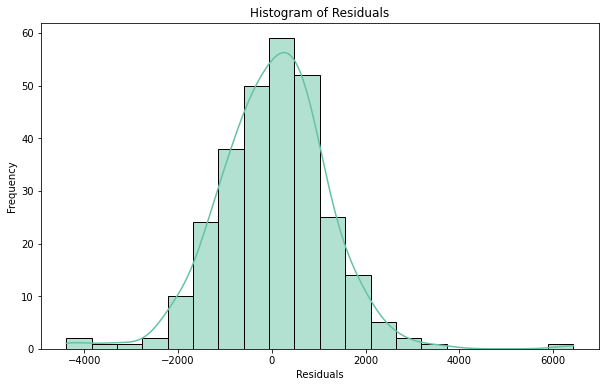

In [190]:
# Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=20)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

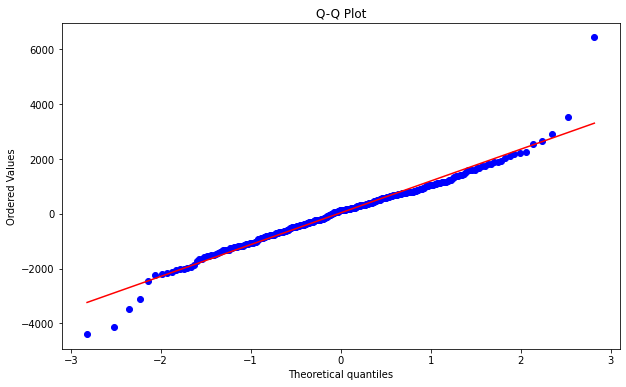

In [191]:
# Q-Q Plot
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

### Residual Analysis Summary
- Linearity: The residuals show no discernible pattern when plotted against the predicted values, indicating that the assumption of linearity is satisfied.
- Homoscedasticity: The spread of the residuals appears consistent across the range of predicted values, confirming constant variance (homoscedasticity).
- Normality: The residuals follow a normal distribution, as observed in the histogram and Q-Q plot. This validates the normality assumption.

# <center>End of Assignment</center>